In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


import os
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')                                        

In [3]:
print("Length of training dataset: ",len(train_data))
print("Length of testing dataset: ",len(test_data))

Length of training dataset:  891
Length of testing dataset:  418


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

In [7]:
whole_data = train_data.append(test_data)
whole_data['Title'] = whole_data.Name.str.extract(r'([A-Za-z]+)\.', expand=False)
whole_data.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Mlle          2
Ms            2
Major         2
Countess      1
Sir           1
Capt          1
Jonkheer      1
Lady          1
Dona          1
Mme           1
Don           1
Name: Title, dtype: int64

In [8]:
Common_Title = ['Mr', 'Miss', 'Mrs', 'Master']
whole_data['Title'].replace(['Ms', 'Mlle', 'Mme'], 'Miss', inplace=True)
whole_data['Title'].replace(['Lady'], 'Mrs', inplace=True)
whole_data['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
whole_data['Title'][~whole_data.Title.isin(Common_Title)] = 'Others'

In [9]:
train_data = whole_data[:len(train_data)]
test_data = whole_data[len(train_data):]

In [10]:
AgeMedian_by_titles = train_data.groupby('Title')['Age'].median()
AgeMedian_by_titles

Title
Master     3.5
Miss      21.5
Mr        30.0
Mrs       35.0
Others    47.0
Name: Age, dtype: float64

In [11]:
for title in AgeMedian_by_titles.index:
    train_data['Age'][(train_data.Age.isnull()) & (train_data.Title == title)] = AgeMedian_by_titles[title]
    test_data['Age'][(test_data.Age.isnull()) & (test_data.Title == title)] = AgeMedian_by_titles[title]

In [12]:
train_data['Embarked'].fillna(train_data.Embarked.mode()[0], inplace=True)

In [13]:
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [14]:
train_data.loc[train_data.Fare>512, 'Fare'] = 263
train_data.Fare.sort_values(ascending=False).head(5)

341    263.0
438    263.0
88     263.0
679    263.0
258    263.0
Name: Fare, dtype: float64

In [15]:
train_data['Sex_Code'] = train_data['Sex'].map({'female':1, 'male':0}).astype('int')
test_data['Sex_Code'] = test_data['Sex'].map({'female':1, 'male':0}).astype('int')

In [16]:
train_data['Embarked_Code'] = train_data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')
test_data['Embarked_Code'] = test_data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')

In [17]:
train_data['AgeBin_5'] = pd.qcut(train_data['Age'], 5)
test_data['AgeBin_5'] = pd.qcut(test_data['Age'], 5)

In [18]:
train_data['FareBin_5'] = pd.qcut(train_data['Fare'], 5)
test_data['FareBin_5'] = pd.qcut(test_data['Fare'], 5)

In [19]:
label = LabelEncoder()
train_data['AgeBin_Code_5'] = label.fit_transform(train_data['AgeBin_5'])
test_data['AgeBin_Code_5'] = label.fit_transform(test_data['AgeBin_5'])
label = LabelEncoder()
train_data['FareBin_Code_5'] = label.fit_transform(train_data['FareBin_5'])
test_data['FareBin_Code_5'] = label.fit_transform(test_data['FareBin_5'])

In [20]:
train_data['FamilySize'] = train_data.SibSp + train_data.Parch + 1
test_data['FamilySize'] = test_data.SibSp + test_data.Parch + 1

In [21]:
train_data['Alone'] = train_data.FamilySize.map(lambda x: 1 if x == 1 else 0)
test_data['Alone'] = test_data.FamilySize.map(lambda x: 1 if x == 1 else 0)

In [22]:
train_data['Title_Code'] = train_data.Title.map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Others':4}).astype('int')
test_data['Title_Code'] = test_data.Title.map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Others':4}).astype('int')

In [23]:
whole_data = train_data.append(test_data)
whole_data['Surname'] = whole_data.Name.str.extract(r'([A-Za-z]+),', expand=False)
whole_data['TixPref'] = whole_data.Ticket.str.extract(r'(.*\d)', expand=False)
whole_data['SurTix'] = whole_data['Surname'] + whole_data['TixPref']
whole_data['IsFamily'] = whole_data.SurTix.duplicated(keep=False)*1

In [24]:
whole_data['Child'] = whole_data.Age.map(lambda x: 1 if x <=16 else 0)
UniqueFamilyTixWithChild = whole_data[(whole_data.IsFamily==1)&(whole_data.Child==1)]['SurTix'].unique()
len(UniqueFamilyTixWithChild)

66

In [25]:
whole_data['FamilyId'] = 0
x = 1
for tix in UniqueFamilyTixWithChild:
 whole_data.loc[whole_data.SurTix==tix, ['FamilyId']] = x
 x += 1

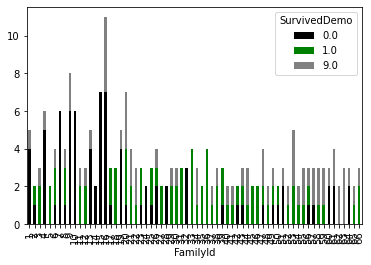

In [26]:
whole_data['SurvivedDemo'] = whole_data['Survived'].fillna(9)
pd.crosstab(whole_data.FamilyId, whole_data.SurvivedDemo).drop([0]).plot(kind='bar', stacked=True, color=['black','g','grey'])
plt.show()

In [27]:
whole_data['ConnectedSurvival'] = 0.5 
Survived_by_FamilyId = whole_data.groupby('FamilyId').Survived.sum()
for i in range(1, len(UniqueFamilyTixWithChild)+1):
    if Survived_by_FamilyId[i] >= 1:
        whole_data.loc[whole_data.FamilyId==i, ['ConnectedSurvival']] = 1
    elif Survived_by_FamilyId[i] == 0:
        whole_data.loc[whole_data.FamilyId==i, ['ConnectedSurvival']] = 0
train_data = whole_data[:len(train_data)]
test_data = whole_data[len(train_data):]

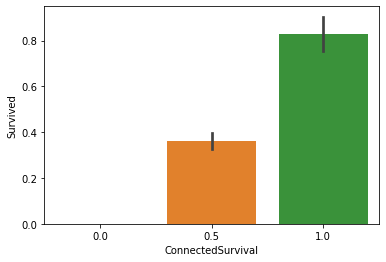

In [44]:
sns.barplot(x='ConnectedSurvival', y='Survived', data=train_data)
plt.show()

In [28]:
X_train = train_data.drop(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Sex', 'SibSp', 'Survived', 'Ticket', 
                           'Title', 'AgeBin_5', 'FareBin_5', 'FamilySize', 'Surname', 'TixPref', 'SurTix', 'IsFamily', 'Child', 
                           'FamilyId'], axis=1)

In [29]:
y_train = train_data['Survived']

In [30]:
model = RandomForestClassifier(n_estimators=200, random_state=2)

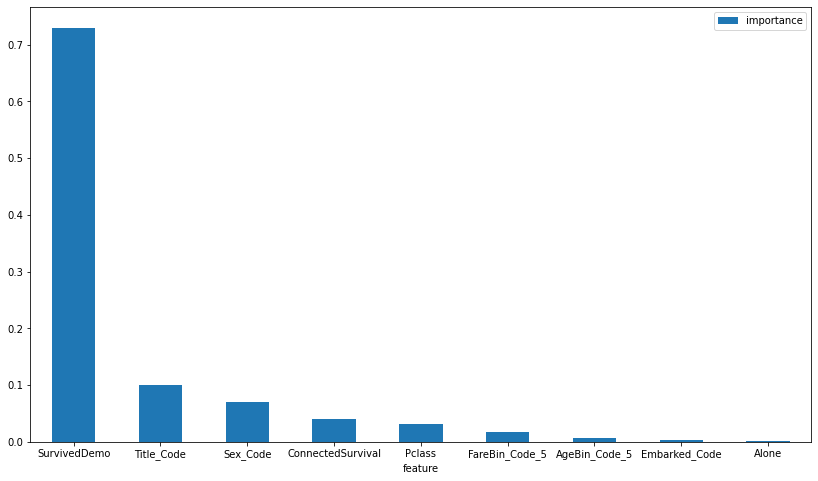

In [49]:
model.fit(X_train,y_train)
importance = pd.DataFrame({'feature':X_train.columns, 'importance': np.round(model.feature_importances_,3)})
importance = importance.sort_values('importance', ascending=False).set_index('feature')
importance.plot(kind='bar', rot=0,figsize=(14,8))
plt.show()

In [52]:
final = ['Title_Code', 'Sex_Code', 'ConnectedSurvival', 'Pclass', 'FareBin_Code_5']

In [53]:
grid_param = {
 'n_estimators': [100, 200, 300],
 'criterion':['gini', 'entropy'],
 'min_samples_split': [2, 10, 20],
 'min_samples_leaf': [1, 5],
 'bootstrap': [True, False],
}
gd_sr = GridSearchCV(estimator=model,
 param_grid=grid_param,
 scoring='accuracy',
 cv=5,
 n_jobs=-1)
gd_sr.fit(X_train[final], y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [61]:
model3 = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion= 'entropy', min_samples_leaf=5, min_samples_split=2,
                                random_state=2)

In [62]:
all_accuracies = cross_val_score(estimator=model1, X=X_train, y=y_train, cv=5)
all_accuracies
all_accuracies.mean()

1.0

In [54]:
from sklearn.linear_model import LogisticRegression
grid_param={"C":np.logspace(-3,3,7), 
            "penalty":["l1","l2"]}
model1=LogisticRegression()
gd_sr_1=GridSearchCV(model2,
                     grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)
gd_sr_1.fit(X_train[final], y_train)
best_parameters = gd_sr_2.best_params_
print(best_parameters)

{'C': 1.0, 'penalty': 'l2'}


In [56]:
model1=LogisticRegression(C=1.0, penalty='l2')

In [57]:
all_accuracies = cross_val_score(estimator=model1, X=X_train, y=y_train, cv=5)
all_accuracies
all_accuracies.mean()

1.0

In [66]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier()

grid_param = {"criterion": ["gini", "entropy"],
    "max_depth" : [2,4,6,8,10]}

gd_sr_2=GridSearchCV(model2,
                     grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)
gd_sr_2.fit(X_train[final], y_train)
best_parameters = gd_sr_3.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 2}


In [67]:
model2 = DecisionTreeClassifier(criterion = 'gini', max_depth= 2)

In [70]:
all_accuracies = cross_val_score(estimator=model2, X=X_train, y=y_train, cv=5)
all_accuracies
all_accuracies.mean()

1.0

In [63]:
X_test = test_data[final]
model1.fit(X_train[final],y_train)
prediction = model1.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction.astype(int)})
output.to_csv('submissionrf.csv', index=False)

In [58]:
X_test = test_data[final]
model2.fit(X_train[final],y_train)
prediction = model2.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction.astype(int)})
output.to_csv('submissionlogistic.csv', index=False)

In [71]:
X_test = test_data[final]
model3.fit(X_train[final],y_train)
prediction = model3.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction.astype(int)})
output.to_csv('submissiondectree.csv', index=False)